In [25]:
from studies.study_factory import StudyFactory
from dataloader.dataloader import DataLoader
from itertools import chain
import random
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch


dataloader = DataLoader(
    buffer_size=10,
    max_cache_size_gb=100,
    cache_dir="cache",
    notch_filter=True,
    frequency_bands={"all": (0.5, 100)},
    scaling="both",
    delay=0.15,
    brain_clipping=20,
    baseline_window=0.5,
    new_freq=100,
    batch_types={"audio": 2},
    batch_kwargs={
        "audio": {
            "max_random_shift": 1,
            "window_size": 30,
            "window_stride": 1,
            "audio_sample_rate": 16000,
            "hop_length": 160,
            "audio_processor": "openai/whisper-large-v3",
        }
    },
)

study = StudyFactory.create_study(
    study_name="gwilliams2023",
    batch_type="audio",
    path="data/gwilliams2023",
    cache_enabled=True,
    max_cache_size=200,  # in items
)


flat_recordings = list(chain.from_iterable(chain.from_iterable(study.recordings)))

Loading Gwilliams2023 with batch type audio


In [26]:
import time

dataloader.start_fetching([flat_recordings[0]], cache=True)

# Process batches as they become available
try:
    batches, recs, start_time = 0, 0, time.time()
    print(f"Total recordings: {len(flat_recordings)}")

    while True:
        batch = dataloader.get_recording()

        if batch is None:
            break

        brain = batch.brain_segments["all"]
        batches += brain.shape[0]
        recs += 1

        if recs % 1 == 0:
            print(
                f"Batch {batches} ({recs} recordings) processed in {time.time() - start_time:.2f}s"
            )
            print(
                f"Average processing time per recording: {(time.time() - start_time) / recs:.2f}s"
            )
            print(
                f"Average processing time per batch: {(time.time() - start_time) / batches:.2f}s"
            )

        break

except KeyboardInterrupt:
    print("Interrupted")
    dataloader.stop()
except Exception as e:
    print("Error", e)
    dataloader.stop()

Total recordings: 196
Batch 132 (1 recordings) processed in 2.69s
Average processing time per recording: 2.69s
Average processing time per batch: 0.02s


Raw signal shape: torch.Size([2, 208, 3000])
Shape of spectrogram: torch.Size([2, 208, 128, 3000])
Size of tensor: 0.64 GB
Estimated num batches per cpu: 10.96


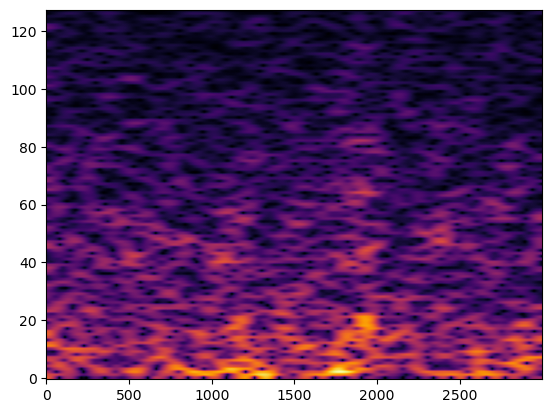

In [6]:
raw = batch.brain_segments["all"][:2]
print(f"Raw signal shape: {raw.shape}")

n_fft = 256
bins = 128
time = raw.shape[-1]

spectrogram_transform = T.Spectrogram(
    n_fft=n_fft,
    hop_length=1,
    normalized=True,
    power=1,
)
spec = torch.log1p(spectrogram_transform(raw[:2]))
spec = spec[:, :, :bins, :time]
print(f"Shape of spectrogram: {spec.shape}")

plt.imshow(spec[0][0].numpy(), aspect="auto", origin="lower", cmap="inferno")
tensor_size = spec.numel() * spec.element_size() / 1e9
print(f"Size of tensor: {tensor_size:.2f} GB")
print(f"Estimated num batches per cpu: {7 / tensor_size:.2f}")

In [ ]:
class SpecConv(torch.nn.Module):
    def __init__(
        self,
    ):
        pass

In [17]:
from torchaudio.models import Conformer

conformer = Conformer(
    input_dim=384,
    num_heads=1,
    ffn_dim=384 * 4,
    num_layers=4,
    depthwise_conv_kernel_size=21,
    dropout=0.2,
    use_group_norm=True,
    convolution_first=False,
).to("mps")

params = sum(p.numel() for p in conformer.parameters())
print(f"Number of parameters: {params}")

Number of parameters: 13644288


In [21]:
input = torch.randn((2, 3000, 384)).to("mps")
lengths = torch.full((input.shape[0],), input.shape[1], dtype=torch.long).to("mps")

out, l = conformer(input, lengths=lengths)

In [24]:
out.shape, l.shape

(torch.Size([2, 3000, 384]), torch.Size([2]))